In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.metrics import peak_signal_noise_ratio as psnr
from patchify import patchify, unpatchify

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = img.resize((128,128))
            img = img.convert('RGB')
            img = np.array(img)
            images.append(img)
    
    images = np.array(images)
    images = images/255
    return images

In [3]:
folder_1 = r"C:\Users\Hp\Downloads\Train\low"
folder_2 = r"C:\Users\Hp\Downloads\Train\high"

In [4]:
x = load_images_from_folder(folder_1)
y = load_images_from_folder(folder_2)

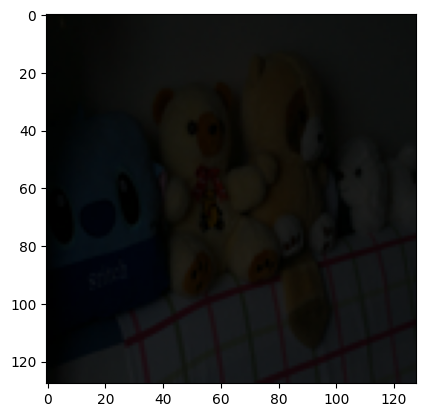

In [5]:
plt.imshow(x[0])
plt.show()

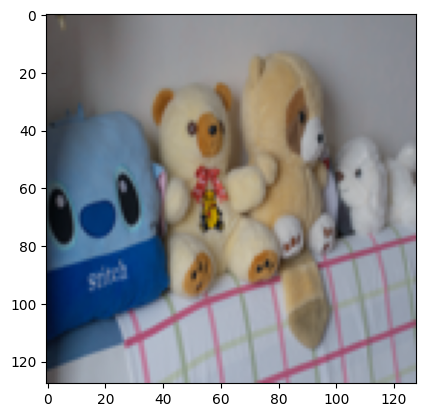

In [6]:
plt.imshow(y[0])
plt.show()

In [7]:
patch_size = 32
x_patches = np.vstack([patchify(img, (patch_size, patch_size, 3), step=patch_size) for img in x])
y_patches = np.vstack([patchify(mask, (patch_size, patch_size, 3), step=patch_size) for mask in y])

x_patches = x_patches.reshape(-1, patch_size, patch_size, 3)
y_patches = y_patches.reshape(-1, patch_size, patch_size, 3)

In [8]:
def model_building(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2), padding='same')(c1)
    p1 = Dropout(0.25)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2), padding='same')(c2)
    p2 = Dropout(0.25)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(p2)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2), padding='same')(c3)
    p3 = Dropout(0.25)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(p3)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2), padding='same')(c4)
    p4 = Dropout(0.25)(p4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(p4)
    c5 = BatchNormalization()(c5)

    # Decoder
    u1 = UpSampling2D((2, 2))(c5)
    concat1 = Concatenate()([u1, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat1)
    c6 = BatchNormalization()(c6)

    u2 = UpSampling2D((2, 2))(c6)
    concat2 = Concatenate()([u2, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat2)
    c7 = BatchNormalization()(c7)

    u3 = UpSampling2D((2, 2))(c7)
    concat3 = Concatenate()([u3, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat3)
    c8 = BatchNormalization()(c8)

    u4 = UpSampling2D((2, 2))(c8)
    concat4 = Concatenate()([u4, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat4)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c9)

    model = Model(inputs, outputs)
    return model

In [9]:

model = model_building((patch_size, patch_size, 3))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
model.fit(x_patches, y_patches, epochs=40, batch_size=32, validation_split=0.1, callbacks=[reduce_lr])